In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import scipy.spatial as spatial

In [2]:
fig_dir = '/Users/lucyowen/Desktop/paper_figures/paper_figs/best_locs'

In [3]:
fig_count = 0

In [63]:
def most_informative_locs_plot(df, vox_size=5, width=10):
    
    locs = plot.compile_df_locs(df['R'])
    
    sub_nii = se.load('std', vox_size=vox_size)
    sub_locs = sub_nii.get_locs().values
    nii = se.load('std', vox_size=vox_size)
    full_locs = nii.get_locs().values
    
    point_tree = spatial.cKDTree(locs)
    
    
    most_info = np.array([])

    for l in sub_locs: 
        most_info = np.append(most_info, df['Correlation'][point_tree.query_ball_point(l, width)].mean())
        
    bo_nii = se.Brain(data=np.atleast_2d(plot.z2r(most_info)), locs=sub_locs)
    nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
    ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
    

# PyFR analysis

In [5]:
pyfr_across = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/pyfr/pyfr_across.csv', index_col=0)
pyfr_within = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/pyfr/pyfr_within.csv', index_col=0)

## Merge dataframes

In [6]:
pyFR_df = pd.merge(pyfr_across, pyfr_within, on=['Subject', 'R'])
pyFR_df.dropna(inplace=True)
pyFR_df.rename(columns={"Correlation_x":"Correlation_Across", "Correlation_y":"Correlation_Within"}, inplace=True)
e_corrs = pd.DataFrame()
e_corrs['across'] = plot.r2z(pyFR_df['Correlation_Across'])
e_corrs['within'] = plot.r2z(pyFR_df['Correlation_Within'])
e_corrs['Subject'] = pyFR_df['Subject']
e_corrs['R'] = pyFR_df['R']

In [7]:
grouped_pyfr_mean = e_corrs.groupby('Subject')['across','within'].mean()

In [8]:
e_corrs['Subject'].head()

0    FR190
1    CH013
2    CH048
3    TJ019
4    FR050
Name: Subject, dtype: object

## Replace correlation for each electrode with the average correlation for each subject 

In [9]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_pyfr_mean.index):


    sub_locs = plot.compile_df_locs(pyfr_across['R'][pyfr_across['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_pyfr_mean['across'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_pyfr_mean['across'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_pyfr_df = pd.DataFrame()
bestloc_pyfr_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_pyfr_df['Subject'] = subj_by_subject
bestloc_pyfr_df['R'] = None



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [10]:
for i in range(bestloc_pyfr_df.shape[0]):
    bestloc_pyfr_df['R'][i] = str(R_locs[i])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
bestloc_pyfr_df.read_csv('/Users/lucyowen/Desktop/paper_figures/pyfr/best_locs.csv', index_col=0)

In [11]:
bo_locs = plot.compile_df_locs(bestloc_pyfr_df[bestloc_pyfr_df['Subject']=='BW001']['R'])
bo_corr = bestloc_pyfr_df[bestloc_pyfr_df['Subject']=='BW001']['Correlation'].values

In [12]:
bo_corr

array([0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527, 0.68426527,
       0.68426527, 0.68426527, 0.68426527, 0.68426527])

/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


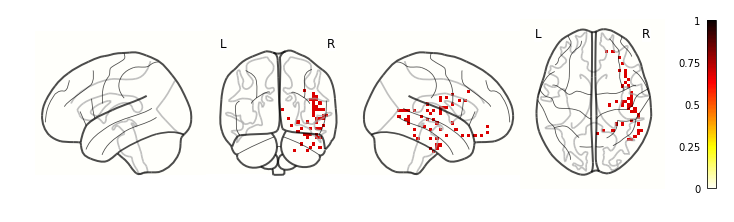

In [13]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(bo_corr), locs=bo_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [14]:
all_locs = plot.compile_df_locs(bestloc_pyfr_df['R'])
all_corr = np.atleast_2d(bestloc_pyfr_df['Correlation'])

## Plot patient average correlation at each electrode location

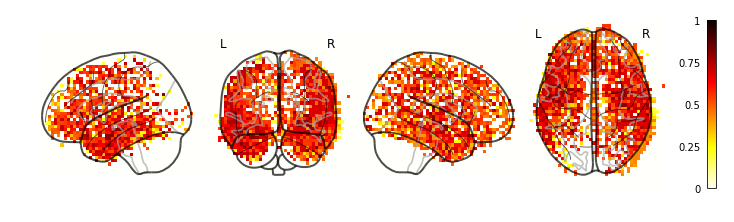

In [15]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=all_corr, locs=all_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [60]:
bestloc_pyfr_df.head()

,Correlation,Subject,R
0,0.684265,BW001,[42.42 -9.47 25.62]
1,0.684265,BW001,[ 40.4 10.97 -14.86]
2,0.684265,BW001,[ 35.35 -19.92 -40.48]
3,0.684265,BW001,[ 51.52 -22.65 -25.15]
4,0.684265,BW001,[ 54.55 -34.13 1.46]


## Plot most informative location (average correlation of subject with electrodes within 5 mni of each location in 4mm brain)

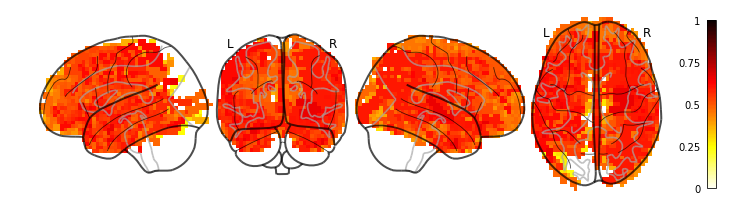

In [25]:
most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=5)

## Same but within 10 mm

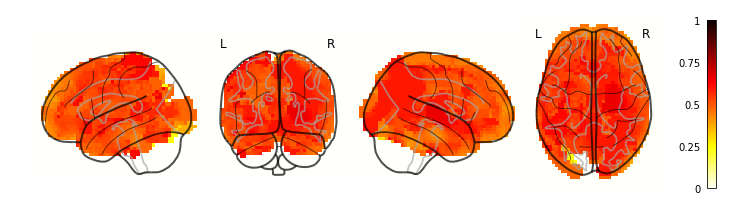

In [18]:
most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=10)

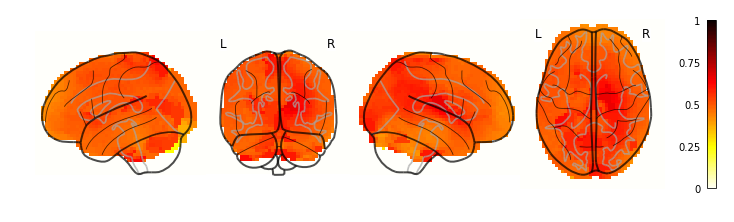

In [19]:
most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=20)

## Same but for 20 mm

## Across vs within subject analysis

In [ ]:
pyfr_locs = plot.compile_df_locs(pyfr_across['R'])
corr_pyfr_locs = np.atleast_2d(pyfr_across['Correlation'])

# RAM

In [88]:
W_a_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-a_exp.csv', index_col=0)
W_a_a.name = 'W_a_a'
W_a_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-all_exp.csv', index_col=0)
W_a_all.name = 'W_a_all'
W_a_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-w_exp.csv', index_col=0)
W_a_w.name = 'W_a_w'
W_w_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-a_exp.csv', index_col=0)
W_w_a.name = 'W_w_a'
W_w_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-all_exp.csv', index_col=0)
W_w_all.name = 'W_w_all'
W_w_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-w_exp.csv', index_col=0)
W_w_w.name = 'W_w_w'

In [89]:
dfs = [W_a_a, W_a_all, W_a_w, W_w_a, W_w_all, W_w_w]

In [90]:
RAM_df = dfs[0]
RAM_df = RAM_df.rename(columns={"Correlation":RAM_df.name})
for df_ in dfs[1:]:
    RAM_df = RAM_df.merge(df_, on=['Subject', 'R'])
    
    RAM_df = RAM_df.rename(columns={"Correlation":df_.name})

In [91]:
RAM_df.head()

,R,W_a_a,Subject,W_a_all,W_a_w,W_w_a,W_w_all,W_w_w
0,[-50.39 18.22 -43.3 ],0.242494,R1083J_RAM_CatFR1_2,0.300987,0.447637,-0.162586,0.236228,0.061755
1,[-46.17 18.21 -42.23],0.177056,R1083J_RAM_CatFR1_1,0.046046,0.478972,0.165845,0.275166,0.292074
2,[-57.19 19.07 -44.75],0.234188,R1083J_RAM_CatFR1_4,0.788364,0.916196,0.542039,-0.021315,0.117429
3,[-43.21 18.21 -41.49],0.336156,R1083J_RAM_CatFR1_0,0.536711,0.796827,0.005241,-0.211179,0.046857
4,[-54.86 15.87 40.38],0.024989,R1032D_RAM_FR1_3,0.426785,0.232029,0.187670,0.312530,0.378536


In [92]:
RAM_df.dropna(inplace=True)

## FR

In [93]:
str_find = '_FR1_'
str_find
FR_df = RAM_df[RAM_df['Subject'].str.contains(str_find)]

In [94]:
fr_locs = plot.compile_df_locs(FR_df['R'])

In [95]:
fr_subject = np.array([])
fr_within = np.array([])
fr_across = np.array([])
fr_R = np.array([])
for i , item in enumerate(FR_df['Subject'].values):
    #print(item.split('_')[0])
    fr_subject = np.append(fr_subject, item.split('_')[0])
    fr_within = np.append(fr_within, FR_df['W_w_w'].iloc[i])
    fr_across = np.append(fr_across, FR_df['W_a_w'].iloc[i])
    fr_R = np.append(fr_R, FR_df['R'].iloc[i])

In [96]:
corr_fr_df = pd.DataFrame()
corr_fr_df['Subject'] = fr_subject
corr_fr_df['W_w_w'] = plot.r2z(fr_within)
corr_fr_df['W_a_w'] = plot.r2z(fr_across)
corr_fr_df['R'] = fr_R

In [97]:
fr_locs = plot.compile_df_locs(corr_fr_df['R'])

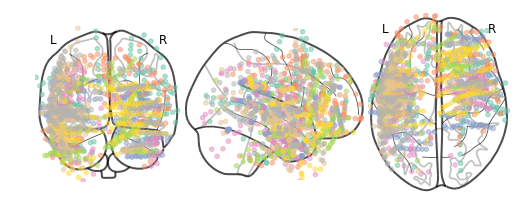

In [98]:
ni_plt.plot_connectome(np.eye(fr_locs.shape[0]), fr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None, 'cmap':'hot'},
                       node_size=20)

## CatFR

In [99]:
str_find = '_CatFR1_'
str_find
CatFR_df = RAM_df[RAM_df['Subject'].str.contains(str_find)]

In [100]:
catfr_subject = np.array([])
catfr_within = np.array([])
catfr_across = np.array([])
catfr_R = np.array([])
for i , item in enumerate(CatFR_df['Subject'].values):
    #print(item.split('_')[0])
    catfr_subject = np.append(catfr_subject, item.split('_')[0])
    catfr_within = np.append(catfr_within, CatFR_df['W_w_w'].iloc[i])
    catfr_across = np.append(catfr_across, CatFR_df['W_a_w'].iloc[i])
    catfr_R = np.append(catfr_R, CatFR_df['R'].iloc[i])

In [101]:
corr_catfr_df = pd.DataFrame()
corr_catfr_df['Subject'] = catfr_subject
corr_catfr_df['W_w_w'] = plot.r2z(catfr_within)
corr_catfr_df['W_a_w'] = plot.r2z(catfr_across)
corr_catfr_df['R'] = catfr_R

In [102]:
catfr_locs = plot.compile_df_locs(corr_catfr_df['R'])

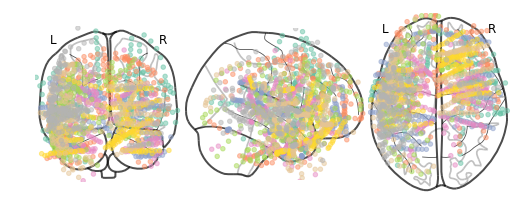

In [103]:
ni_plt.plot_connectome(np.eye(catfr_locs.shape[0]), catfr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None, 'cmap':'hot'},
                       node_size=20)

## All within

In [104]:
all_subject = np.array([])
all_within = np.array([])
all_across = np.array([])
all_R = np.array([])
for i , item in enumerate(RAM_df['Subject'].values):
    #print(item.split('_')[0])
    all_subject = np.append(all_subject, item.split('_')[0])
    all_within = np.append(all_within, RAM_df['W_w_w'].iloc[i])
    all_across = np.append(all_across, RAM_df['W_a_w'].iloc[i])
    all_R = np.append(all_R, RAM_df['R'].iloc[i])

In [106]:
corr_all_df = pd.DataFrame()
corr_all_df['Subject'] = all_subject
corr_all_df['W_w_w'] = plot.r2z(all_within)
corr_all_df['W_a_w'] = plot.r2z(all_across)
corr_all_df['R'] = all_R

In [107]:
grouped_all_mean = corr_all_df.groupby('Subject')['W_w_w','W_a_w'].mean()

In [109]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_all_mean.index):


    sub_locs = plot.compile_df_locs(corr_all_df['R'][corr_all_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_all_mean['W_a_w'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_all_mean['W_a_w'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_all_df = pd.DataFrame()
bestloc_all_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_all_df['Subject'] = subj_by_subject
bestloc_all_df['R'] = None



In [110]:
for i in range(bestloc_all_df.shape[0]):
    bestloc_all_df['R'][i] = str(R_locs[i])

In [113]:
bestloc_all_df.to_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/best_locs.csv')

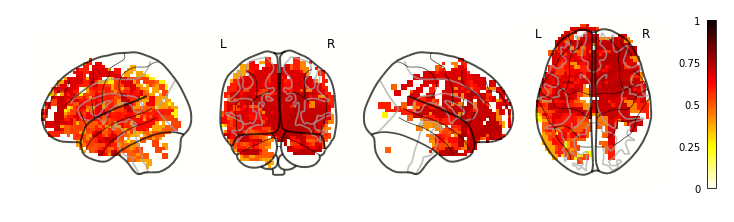

In [111]:
most_informative_locs_plot(bestloc_all_df, vox_size=4, width=5)

## Across

In [70]:
A_a_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-a_exp.csv', index_col=0)
A_a_a.name = 'A_a_a'
A_a_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-all_exp.csv', index_col=0)
A_a_all.name = 'A_a_all'
A_a_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-w_exp.csv', index_col=0)
A_a_w.name = 'A_a_w'
A_w_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-a_exp.csv', index_col=0)
A_w_a.name = 'A_w_a'
A_w_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-all_exp.csv', index_col=0)
A_w_all.name = 'A_w_all'
A_w_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-w_exp.csv', index_col=0)
A_w_w.name = 'A_w_w'

In [71]:
dfs_2 = [A_a_a, A_a_all, A_a_w, A_w_w]

In [72]:
RAM_df_2 = dfs_2[0]
RAM_df_2 = RAM_df_2.rename(columns={"Correlation":RAM_df_2.name})
for df_ in dfs_2[1:]:
    RAM_df_2 = RAM_df_2.merge(df_, on=['Subject', 'R'])
    RAM_df_2 = RAM_df_2.rename(columns={"Correlation":df_.name})

In [73]:
RAM_df_2.dropna(inplace=True)

In [74]:
ram_subject = np.array([])
ram_within = np.array([])
ram_across = np.array([])
ram_R = np.array([])
for i , item in enumerate(RAM_df_2['Subject'].values):
    #print(item.split('_')[0])
    ram_subject = np.append(ram_subject, item.split('_')[0])
    ram_within = np.append(ram_within, RAM_df_2['A_w_w'].iloc[i])
    ram_across = np.append(ram_across, RAM_df_2['A_a_w'].iloc[i])
    ram_R = np.append(ram_R, RAM_df_2['R'].iloc[i])

In [75]:
corr_ram_df = pd.DataFrame()
corr_ram_df['Subject'] = ram_subject
corr_ram_df['A_w_w'] = plot.r2z(ram_within)
corr_ram_df['A_a_w'] = plot.r2z(ram_across)
corr_ram_df['R'] = ram_R

In [76]:
grouped_ram_mean = corr_ram_df.groupby('Subject')['A_w_w','A_a_w'].mean()

In [77]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_ram_mean.index):


    sub_locs = plot.compile_df_locs(corr_ram_df['R'][corr_ram_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_ram_mean['A_a_w'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_ram_mean['A_a_w'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_ram_df = pd.DataFrame()
bestloc_ram_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_ram_df['Subject'] = subj_by_subject
bestloc_ram_df['R'] = None



In [78]:
for i in range(bestloc_ram_df.shape[0]):
    bestloc_ram_df['R'][i] = str(R_locs[i])

In [57]:
bestloc_ram_df.to_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/best_ram_locs.csv')

In [58]:
bestloc_ram_df = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/best_locs.csv', index_col=0)

In [79]:
bestloc_ram_df.head()

,Correlation,Subject,R
0,0.677347,R1032D,[-61.62 -2.9 32.75]
1,0.677347,R1032D,[-38.79 51.43 47.05]
2,0.677347,R1032D,[-52.44 24.4 43.61]
3,0.677347,R1032D,[-11.52 24.24 64.04]
4,0.677347,R1032D,[-11.17 31.11 47.29]


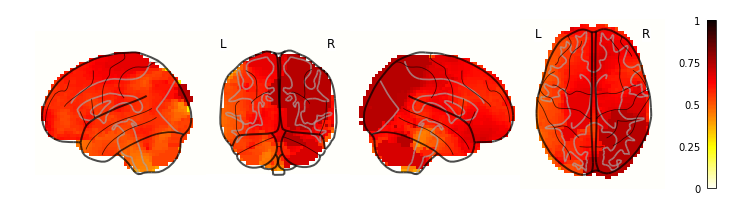

In [80]:
most_informative_locs_plot(bestloc_ram_df, vox_size=4, width=20)

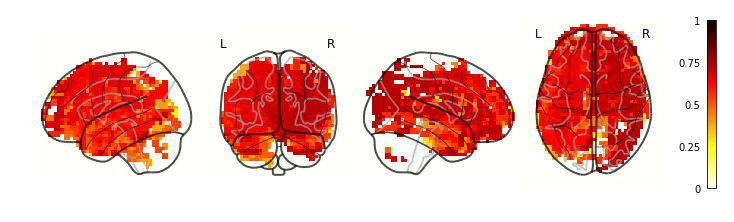

In [81]:
most_informative_locs_plot(bestloc_ram_df, vox_size=4, width=5)

In [82]:
all_locs = plot.compile_df_locs(bestloc_ram_df['R'])
all_corr = np.atleast_2d(bestloc_ram_df['Correlation'])

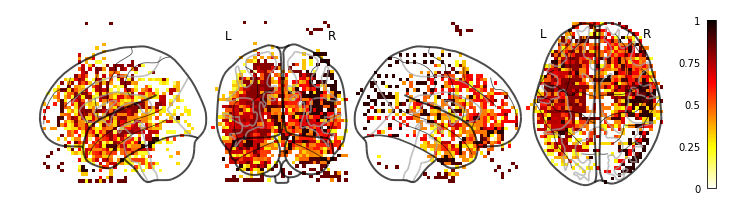

In [83]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=all_corr, locs=all_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, vmax=1, vmin=0, display_mode='lyrz')

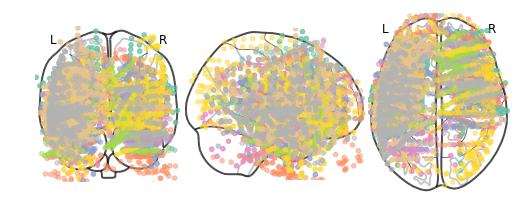

In [86]:
ni_plt.plot_connectome(np.eye(all_locs.shape[0]), all_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None, 'cmap':'hot'},
                       node_size=20)